In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
import nltk
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [14]:
def sample_data(data, label_value, reduction_factor):
    label_data = data[data['label'] == label_value]
    sampled_data = label_data.sample(frac=reduction_factor, random_state=42)
    return sampled_data

data = pd.read_csv('data/text.csv', encoding='utf-8')

reduction_factors = {
    0: 1/10,
    1: 1/10,
    2: 1/3,
    3: 1/5,
    4: 1/4
}
sampled_data = pd.DataFrame()

for label, reduction_factor in reduction_factors.items():
    sampled_label_data = sample_data(data, label, reduction_factor)
    sampled_data = pd.concat([sampled_data, sampled_label_data])

# save label=5
label_5 = data[data['label'] == 5]
data = pd.concat([sampled_data, label_5])

# Disorder
data = data.sample(frac=1, random_state=42)
print(data['label'].value_counts())

label
5    14972
1    14107
0    12119
4    11928
2    11518
3    11463
Name: count, dtype: int64


#### Data pre-processing

In [16]:
def contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "ily":"I love you",
        "Ily":"I love you",
        "Ihy":"I hate you",
        "ihy":"I hate you",
        "imy":"I miss you",
        "Imy":"I miss you",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "im":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "sux":"sucks",
        "shit":"bad",
        "tmr":"tomorrow",
        "tmrw":"tomorrow",
        "u":"you",
        "ur":"your",
        "k":"okay",
        "ok":"okay",
        "da":"the",
        "tom":"tomorrow",
        "Tom":"tomorrow",
        "v'll":"we will",
        "wassup":"what is up with you",
        "waddup":"what is up with you",
        "yo":"greet",
        "hey":"greet",
        "lol":"laugh",
        "lmao":"laugh",
        "Lmao":"laugh",
        "rofl":"laugh",
        "y":"why",
        "wut":"what",
        "wat":"what",
        "stfu":"angry",
        "wtf":"angry",
        "ya":"yes",
        "yeah":"yes",
        "ummmm":"confused",
        "ummm":"confused",
        "umm":"confused",
        "hmmm":"confused",
        "i'm":"I am",
        "awww":"amazement",
        "Awww":"amazement",
        "aww":"amazement",
        "Aww":"amazement",
        "can't":"cannot",
        "Can't":"cannot",
        "CAN'T":"cannot",
        "awe":"amazement",
        "Awe":"amazement",
        "ugh":"sad",
        "ughh":"sad",
        "Ugh":"sad",
        "Ughh":"sad",
        "UGHH":"sad",
        "ughhhh":"sad",
        "ughhh":"sad"
        }

In [17]:
from nltk.corpus import stopwords 

def removal_of_noise(sent):
    clean_sent=[]
    temp_st=""
    list_sent=sent.split(" ")
    c=0
    d=contractions()
    
    for word in list_sent:
        #removal of url
        word = re.sub(r"http\S+", "", word)
        word = re.sub(r"[www.][a-zA-Z0-9_]+[.com]", "", word)
        #removal of account handles '@'
        word = re.sub("(@[A-Za-z0-9_]+)","", word) 
        
        #replacing short form words with their full form
        if(word.lower() in d.keys()):
            word=d[word.lower()]
        if(c==0):
            temp_st=word
        else:
            temp_st=temp_st+" "+word
        c=c+1
    sent=temp_st
    stop_words = set(stopwords.words('english'))
    for word in word_tokenize(sent):
        if(word.lower() not in stop_words and word.lower() not in string.punctuation and word!="'" and word!='"' ):
            word=re.sub("[0-9]+","",word)
            word=re.sub("[.]+"," ",word)
            word=re.sub("[-]+"," ",word)
            word=re.sub("[_]+"," ",word)
            word = re.sub("~"," ", word) 
            if(len(word)!=1):
                clean_sent.append(word.lower())
    cleaned_st=""
    for i in clean_sent:
        cleaned_st=cleaned_st+" "+i
    #print(cleaned_st)
    return cleaned_st

In [18]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

def start(text):
    #removes html tags
    text =text.replace("’","'")
    new_text=sent_tokenize(text)
    #print((new_text))
    result=0
    new_str=""
    #removing emojis
    for i in new_text:
        res=removal_of_noise(i)
        new_str=new_str+" "+res
    return new_str


In [19]:
l=[]
for i in data['text']:
    x = start(i)
    l.append(x)

data['sentence']=l

In [20]:
data['sentence'].to_csv('data/reviews.txt', index=False, header=None)
data['label'].to_csv('data/labels.txt', index=False, header=None)

# read data from text files
with open('data/reviews.txt', 'r', encoding = 'utf-8') as f:
    reviews = f.read()
with open('data/labels.txt', 'r', encoding='utf-8') as f:
    labels = f.read()

In [21]:
from string import punctuation
print(punctuation)

# get rid of punctuation
reviews = reviews.lower() # lowercase, standardize
all_text = ''.join([c for c in reviews if c not in punctuation])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [22]:
# split by new lines and spaces
reviews_split = all_text.split('\n')
all_text = ' '.join(reviews_split)

# create a list of words
words = all_text.split()

words[:10]

['really',
 'bad',
 'sore',
 'throat',
 'feeling',
 'py',
 'feel',
 'une',
 'shop',
 'feeling']

#### Encoding the words

In [23]:
from collections import Counter

## Build a dictionary that maps words to integers
count = Counter(words)
vocab = sorted(count,key=count.get,reverse=True)
# enumerate(iterable, start=0)
vocab_to_int = {word:i for i,word in enumerate(vocab,1)}

## use the dict to tokenize each review in reviews_split
## store the tokenized reviews in reviews_ints
reviews_ints = [[vocab_to_int[word] for word in review.split()] for review in reviews_split]

In [24]:
# stats about vocabulary
print('Unique words: ', len((vocab_to_int)))  # should ~ 74000+
print()

# print tokens in first review
print('Tokenized review: \n', reviews_ints[0][:10])

Unique words:  33123

Tokenized review: 
 [4, 110, 1378, 1606, 2, 1399]


#### Encoding the labels

In [25]:
encoded_labels = [0 if label == '0' else
                  (1 if label == '1' else
                   (2 if label == '2' else
                    (3 if label == '3' else
                     (4 if label == '4' else 5)))) for label in labels.split('\n')]
print(encoded_labels[:20])
# print(labels.split('\n'))

[4, 0, 4, 5, 0, 1, 4, 4, 5, 4, 0, 0, 5, 1, 4, 1, 0, 2, 2, 3]


#### Removing Outliers

In [26]:
# outlier review stats
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 2
Maximum review length: 45


In [27]:
print('Number of reviews before removing outliers: ', len(reviews_ints))

## remove any reviews/labels with zero length from the reviews_ints list.
review_nonzero_idx = [i  for i,review in enumerate(reviews_ints) if(len(review)!=0)]

reviews_ints = [reviews_ints[i] for i in review_nonzero_idx]
encoded_labels = [encoded_labels[i] for i in review_nonzero_idx]

print('Number of reviews after removing outliers: ', len(reviews_ints))

Number of reviews before removing outliers:  76108
Number of reviews after removing outliers:  76106


#### Padding sequences

In [28]:
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    ## implement function
    features = np.zeros((len(reviews_ints),seq_length),dtype=np.int32)
    
    for i in range(len(reviews_ints)):
      features[i,-len(reviews_ints[i]):] = reviews_ints[i][:seq_length]
    
    return features

In [29]:
# Test your implementation!

seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

print(features)

[[   0    0    0 ... 1606    2 1399]
 [   0    0    0 ...    1  933 1379]
 [   0    0    0 ...   16  347 1069]
 ...
 [   0    0    0 ... 4142  235 2126]
 [   0    0    0 ...  117 3374 1307]
 [   0    0    0 ...    0    2  802]]


#### Training, Validation, Test

In [30]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)
encoded_labels = np.array(encoded_labels)


length = len(features)
split = int(split_frac*length)

train_x,valid_x = features[:split],features[split:]
train_y,valid_y = encoded_labels[:split],encoded_labels[split:]

test_x,test_y = valid_x[len(valid_x)//2:],valid_y[len(valid_y)//2:]
valid_x,valid_y = valid_x[:len(valid_x)//2],valid_y[:len(valid_y)//2]
## print out the shapes of your resultant feature data
print('Train set : ',train_x.shape,train_y.shape)
print('Validation set : ',valid_x.shape,valid_y.shape)
print('Test set : ',test_x.shape,test_y.shape)


Train set :  (60884, 200) (60884,)
Validation set :  (7611, 200) (7611,)
Test set :  (7611, 200) (7611,)


#### DataLoaders and Batching

In [31]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [32]:
dataiter = iter(train_loader) # create a iteration
sample_x, sample_y = next(dataiter) # Gets the data for the next batch from the iterator

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 200])
Sample input: 
 tensor([[   0,    0,    0,  ..., 1144,   82,   67],
        [   0,    0,    0,  ...,  169,    2,  549],
        [   0,    0,    0,  ..., 4514, 6349, 9290],
        ...,
        [   0,    0,    0,  ...,    9,  962,  285],
        [   0,    0,    0,  ...,  720,   15,  652],
        [   0,    0,    0,  ...,  182, 1147,   31]], dtype=torch.int32)

Sample label size:  torch.Size([50])
Sample label: 
 tensor([2, 3, 2, 1, 1, 3, 5, 2, 5, 5, 1, 2, 0, 1, 3, 2, 5, 3, 1, 5, 0, 0, 0, 0,
        1, 0, 2, 5, 5, 0, 0, 3, 4, 2, 1, 5, 2, 2, 5, 0, 4, 2, 4, 3, 1, 3, 2, 4,
        0, 0], dtype=torch.int32)


#### SentimentRNN

In [33]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [34]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # define all layers
        self.embed = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            n_layers,
                            dropout=drop_prob,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.relu = nn.ReLU()
        self.drp = nn.Dropout(drop_prob)
        self.softmax = nn.Softmax()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        
        x = self.embed(x)
       
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]
        
        out = self.drp(lstm_out)
        out = self.fc(out)
        
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        
        return hidden
        

In [35]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab)+1
output_size = 6
embedding_dim = 400
hidden_dim = 320
n_layers = 3

net = None
net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embed): Embedding(33124, 400)
  (lstm): LSTM(400, 320, num_layers=3, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=320, out_features=6, bias=True)
  (relu): ReLU()
  (drp): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=None)
)


In [36]:
# loss and optimization functions
lr=1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [37]:
# training params
validLoss,trainLoss = [],[]
epochs = 5 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping
minValidLoss = np.inf #use for saving model whenever valid loss becomes less than min valid loss

# move model to GPU, if available
device = 'cuda' if(torch.cuda.is_available()) else 'cpu'
net.to(device)
print("Running on",device)

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    print()
    for batch,(inputs, labels) in enumerate(train_loader,1):
        print(f'\rBatch : {batch}/{len(train_loader)}',end='')
        counter += 1
        
        if(train_on_gpu):
            nputs, labels = inputs.to(device), labels.to(torch.long)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        optimizer.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.long())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
    else:
        # Get validation loss
        print()
        val_h = net.init_hidden(batch_size)
        val_losses = []
        net.eval()
        for inputs, labels in valid_loader:

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])

            if(train_on_gpu):
                nputs, labels = inputs.to(device), labels.to(torch.long)

            output, val_h = net(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.long())

            val_losses.append(val_loss.item())

        net.train()
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.6f}...".format(loss.item()),
              "Val Loss: {:.6f}".format(np.mean(val_losses)))
        
        if(np.mean(val_losses)<minValidLoss):
          print('\t\t...Saving Model...')
          torch.save(net.state_dict(),'LSTM_Model.pt')
          minValidLoss = np.mean(val_losses)
          
        trainLoss.append(loss.item())
        validLoss.append(np.mean(val_losses))
        

Running on cpu

Batch : 1218/1218
Epoch: 1/5... Step: 1218... Loss: 0.431887... Val Loss: 0.448571
		...Saving Model...

Batch : 1218/1218
Epoch: 2/5... Step: 2436... Loss: 0.243448... Val Loss: 0.261336
		...Saving Model...

Batch : 1218/1218
Epoch: 3/5... Step: 3654... Loss: 0.082552... Val Loss: 0.196403
		...Saving Model...

Batch : 1218/1218
Epoch: 4/5... Step: 4872... Loss: 0.133075... Val Loss: 0.179522
		...Saving Model...

Batch : 1218/1218
Epoch: 5/5... Step: 6090... Loss: 0.049604... Val Loss: 0.170171
		...Saving Model...


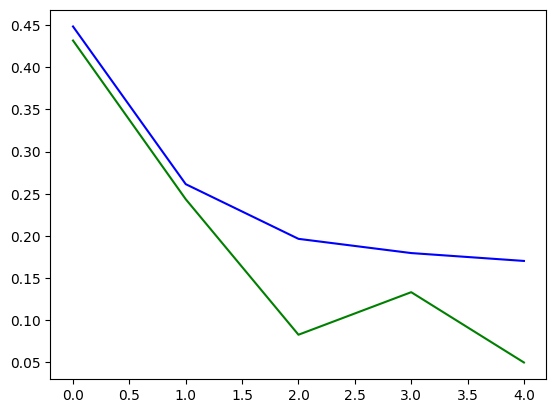

In [38]:
import matplotlib.pyplot as plt
plt.plot(trainLoss[:5],color='g')
plt.plot(validLoss[:5],color='b')
plt.show()

In [39]:
#Loading saved model
net.load_state_dict(torch.load('LSTM_Model.pt'))

if(train_on_gpu):
  net.to('cuda')
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda().long(), labels.cuda().long()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.long())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    # pred = torch.round(output.squeeze())  # rounds to the nearest integer
    pred = torch.argmax(output, dim=1)
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred).long())
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.175
Test accuracy: 0.937


#### Inference on a test review

In [122]:
folder_path = 'News/Big Sample/The time of Indians/output_texts'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
sentiment_values = [1, 2, 3, 4, 5, 6]

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    for line in lines:
        i = start(line)
        NI = i.strip()
        ints = [vocab_to_int.get(word.lower(), 0) for word in NI.split()]
        ints = ints[:seq_length]
        while len(ints) < seq_length:
            ints.append(0)
        features = np.array(ints).reshape(1, -1)
        features = torch.from_numpy(features)
    
        hidden = net.init_hidden(batch_size)
        net.eval()
        output, _ = net(features.long(), hidden)
    
        # covert output to probabilities
        pred_probs = F.softmax(output, dim=1)
        # find the class with maximum probability
        _, predicted = torch.max(pred_probs, dim=1)

        predicted_class = predicted.item()
        value = sentiment_values[predicted_class - 1]
        print('The sentiment value of the text is: ', value)

The sentiment value of the text is:  6
The sentiment value of the text is:  4
The sentiment value of the text is:  3
The sentiment value of the text is:  4
The sentiment value of the text is:  4
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  6
The sentiment value of the text is:  4
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  4
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  4
The sentiment value of the text is:  4
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of the text is:  3
The sentiment value of th